In [153]:
from rosemary import jpt_in_notebook
from llm.submit import submit_job, multiline_to_singleline

shell_scripts_template = """
echo "Running on $SLURM_JOB_NODELIST"
echo "======"

master_addr=$(scontrol show hostnames "$SLURM_JOB_NODELIST" | head -n 1)
master_port=10002
RDZV_ENDPOINT=$master_addr:$master_port

source ~/.profile
conda activate open-instruct
cd /gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts

set -e
set -x
echo "======"
srun {cmd}

[ ! -f "{log_dir}/$SLURM_JOB_ID*.out" ] && mv {log_dir}/$SLURM_JOB_ID*.out {save_dir}
"""
nodes = 2; gpus=6
nodes = 1; gpus=6

test_run = 0
test_run = bool(test_run)


model_name = 'llama-7b'; model_name_or_path = '../results/baselines/huggyllama/llama-7b'
# model_name = 'llama-7b_tulu_v1_human_mix'; model_name_or_path = '../results/ft1/llama-7b_humanmix'

save_dir = f"/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/model_outputs/{model_name}"
log_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/'

datasets = ['flan2022_1m']

for dataset in datasets:
    cmd = f"""
    torchrun --nnodes={nodes} --nproc_per_node={gpus} \
        --rdzv-id=$SLURM_JOB_ID --rdzv-backend=c10d --rdzv-endpoint=$RDZV_ENDPOINT \
        note_llama_embeddings.py \
        --dataset {dataset} \
        --model_name_or_path {model_name_or_path} \
        --save_dir {save_dir} \
        --use_dist \
        --shuffle
    """
    cmd = multiline_to_singleline(cmd)

    shell_scripts = shell_scripts_template.format(
        cmd=cmd, log_dir=log_dir, save_dir=save_dir)
    out = submit_job(
        shell_scripts, 
        job_name=f'LM_outputs.{dataset}', 
        nodes=nodes,
        num_cpus=32,
        cpu_mem=64,
        num_gpus=gpus,
        gpu_type='v100',
        test_run=test_run,
        job_duration=6,
    )
    print(cmd)
    if not test_run:
        print(out)


Submiting job with:
{
    "job_name": "LM_outputs.lima",
    "nodes": 1,
    "num_cpus": 32,
    "cpu_mem": 64,
    "num_gpus": 6,
    "gpu_type": "v100",
    "test_run": false,
    "queue": "el8",
    "num_jobs": 1
}
torchrun --nnodes=1 --nproc_per_node=6 --rdzv-id=$SLURM_JOB_ID --rdzv-backend=c10d --rdzv-endpoint=$RDZV_ENDPOINT note_llama_embeddings.py --dataset lima --model_name_or_path ../results/baselines/huggyllama/llama-7b --save_dir /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/model_outputs/llama-7b --use_dist --shuffle
[{'args': 'sbatch --job-name=LM_outputs.lima --partition=el8 --nodes=1 --ntasks-per-node=1 --cpus-per-task=32 --mem=64GB --gres=gpu:6 --output=/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/%J.out --time=6:00:00 /gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/tmp_9613eag', 'job_id': 982543}]


In [51]:
import os

processed_dir = '../data/processed'
datasets = []
for dataset in os.listdir(processed_dir) + ['tulu_v1_human_mix', 'tulu_v2_human_mix']:
    dataset_path = os.path.join(processed_dir, dataset)
    save_path = os.path.join(save_dir, f'{dataset}.pkl')
    if 'tulu'==dataset:
        continue
    if 'tulu' not in dataset and not os.path.isdir(dataset_path):
        continue
    if os.path.isfile(save_path):
        continue
    datasets.append(dataset)
    
datasets
    

['flan2022']

In [24]:
from rosemary import jpt_parse_args, jpt_setup, jpt_in_notebook; jpt_setup()

if jpt_in_notebook():
    import os
    
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [139]:
from functools import partial
import os
import numpy as np
import time

import pickle
from tqdm import tqdm 

import pyarrow # import before `torch`, `transformers`, `datasets`
import torch
from torch.utils.data import DataLoader

from datasets import load_dataset

from transformers import AutoModelForCausalLM, AutoTokenizer

from open_instruct.finetune_trainer import encode_with_prompt_completion_format, encode_with_messages_format
from note_llama_embeddings import combine_lm_outputs_for_mixes, datasets_shard_chunk_size


In [58]:
test_run = True
shuffle = False

model_name = 'llama-7b'; model_name_or_path = '../results/baselines/huggyllama/llama-7b'
save_dir = f"/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/model_outputs/{model_name}"
os.makedirs(save_dir, exist_ok=True)

In [57]:
model = AutoModelForCausalLM.from_pretrained(
    model_name_or_path,
    device_map='cuda:0',
    torch_dtype=torch.float16)
model.eval()

tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path, use_fast=True)
tokenizer.padding_side = 'left'
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.


In [59]:
dataset = 'lima'
use_dist = False


if dataset in ['tulu_v1_human_mix', 'tulu_v2_human_mix']:
    combine_lm_outputs_for_mixes(dataset, save_dir)


if use_dist:
    dist.init_process_group("gloo", timeout=datetime.timedelta(hours=6))
    world_size = dist.get_world_size()
    rank = dist.get_rank() # global rank
    local_rank = int(os.environ["LOCAL_RANK"])
else:
    rank = 0
    local_rank = 0
    world_size = 1

print(f'rank/local_rank/world_size: {rank}/{local_rank}/{world_size}\n')

device = f'cuda:{str(local_rank)}'


rank/local_rank/world_size: 0/0/1



In [60]:
processed_dir = '../data/processed'
if 'flan2022' in dataset:
    train_file = os.path.join(processed_dir, 'flan2022', f'{dataset}_data.jsonl')
else:
    train_file = os.path.join(processed_dir, dataset, f'{dataset}_data.jsonl')
assert(os.path.isfile(train_file))

data_files = {'train': train_file}
raw_datasets = load_dataset("json", data_files=data_files)
# if test_run:
#     raw_datasets['train'] = raw_datasets['train'].select(range(100))
print(f"{dataset} dataset length = {len(raw_datasets['train'])}")


encode_function = partial(
    encode_with_messages_format, tokenizer=tokenizer, max_seq_length=2048)

if rank == 0:
    lm_datasets = raw_datasets.map(
        encode_function, batched=False, num_proc=16,
        desc="Tokenizing and reformatting instruction data")
if use_dist:
    dist.barrier()
if rank!= 0:
    lm_datasets = raw_datasets.map(
        encode_function, batched=False, num_proc=16,
        desc="Tokenizing and reformatting instruction data")

train_dataset = lm_datasets['train']
train_dataset.set_format(
    type="torch",
    output_all_columns=False,
    columns=['input_ids', 'labels', 'attention_mask'])
if shuffle:
    random.seed(0)
    shuffle_inds = list(range(len(train_dataset)))
    random.shuffle(shuffle_inds)
    reverse_shuffle_inds = [(i, ind) for i, ind in enumerate(shuffle_inds)]
    reverse_shuffle_inds = sorted(reverse_shuffle_inds, key=lambda x: x[1])
    reverse_shuffle_inds = [x[0] for x in reverse_shuffle_inds]
    train_dataset = train_dataset.select(shuffle_inds)
train_dataset_chunk_sizes = [datasets_shard_chunk_size(len(train_dataset), num_shards=world_size, index=i) 
            for i in range(world_size)]
train_dataset = train_dataset.shard(
    num_shards=world_size, 
    index=rank,
    contiguous=True)
loader = DataLoader(train_dataset, shuffle=False, batch_size=1, pin_memory=True) 

Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-1ca1bac0eed76345/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

lima dataset length = 1030


Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-1ca1bac0eed76345/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-9b36aaea85ca4063_*_of_00016.arrow


In [147]:

text_embeddings = []
log_probs = []
el2ns = []
for batch in tqdm(loader, disable=rank!=0, total=len(loader)):
    batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
    with torch.inference_mode():
        outputs = model(**batch, output_hidden_states=True)

    # (bsz, seq_len, hidden_size) -> (bsz, hidden_size)
    text_embedding = outputs['hidden_states'][-1].mean(1)
    # average of output token log probs
    log_prob = -outputs['loss']
    # compute EL2N score
    el2n = compute_el2n(outputs['logits'], batch['labels'])

    text_embeddings.append(text_embedding.detach().cpu())
    log_probs.append(log_prob.detach().cpu())
    el2ns.append(el2n.detach().cpu())
    break

  0%|          | 0/1030 [00:00<?, ?it/s]


In [151]:
el2ns[0].dtype

torch.float32

NameError: name 'el2ns' is not defined

In [ ]:
train_dataset.shard(num_shards=3, index=2, contiguous=True)['id']


In [80]:
# (B, |Seq|, |Vocab|)
outputs['logits'].shape

torch.Size([1, 449, 32000])

In [144]:

labels = batch['labels']
logits = outputs['logits']



compute_el2n(logits, labels)

tensor(0.6028, device='cuda:0')

In [145]:


def compute_el2n(logits, labels):
    if logits.shape[0]!=1:
        raise ValueError('compute_el2n supports bsz=1 only.')
    # (Bsz, |Seq|, |Vocab|)
    # Shift so that tokens < n predict n
    shift_logits = logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()
    # Flatten the tokens
    # (Bsz*|Seq|, |Vocab|)
    shift_logits = shift_logits.view(-1, model.config.vocab_size)
    shift_probs = torch.nn.functional.softmax(shift_logits, dim=-1)
    shift_labels = shift_labels.view(-1)
    # only compute loss on the output tokens
    output_tok_indices = (shift_labels != -100).nonzero().squeeze()
    shift_labels = shift_labels[output_tok_indices]
    shift_probs = shift_probs[output_tok_indices]
    shift_logits = shift_logits[output_tok_indices]

    # Enable model parallelism
    shift_labels = shift_labels.to(shift_logits.device)
    # Compute EL2N = || prob - one-hot-y ||_2
    shift_probs[torch.arange(shift_probs.size(0)), shift_labels] -= 1
    loss = torch.norm(shift_probs, dim=-1).mean()
    return loss

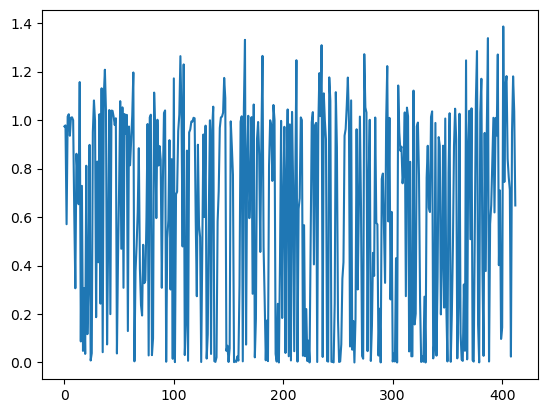

In [132]:
plt.plot(loss.to('cpu').numpy())

In [124]:

# Example matrices
probabilities = torch.tensor([[0.2, 0.3, 0.5],
                              [0.1, 0.7, 0.2],
                              [0.6, 0.1, 0.3]])

# one_hot_labels = torch.tensor([[0, 1, 0],
#                                [1, 0, 0],
#                                [0, 0, 1]])


# one_hot_labels = torch.tensor([1,0,2]).view(-1)


# probabilities[torch.arange(probabilities.size(0)), one_hot_labels] *= -1

# probabilities

In [121]:
loss

tensor(1.8580, device='cuda:0')